# call the libraries

In [1]:
from pyspark.sql import SparkSession
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import io
import numpy as np
import os


import scipy.stats as stats
import numpy as np
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder
%matplotlib inline
import pickle


# initialize spark and spark context

In [2]:
spark = SparkSession.builder.appName('demo-anomaly-profile-dome9-ip-sklearn-isolationforest-batch-train').getOrCreate()
sc = spark.sparkContext
sc.version

'2.1.1'

In [3]:
data_source = "dome9"
tenant_name = "demo"
time_window="day"
entity_type="ip"
anomaly_type="profile"
model_type="sklearn"
model_name="isolationforest"

BASE_PATH = "/Users/tuhinsharma/Documents/sstech/"+tenant_name
ANOMALY_DATA_REPOSITORY = BASE_PATH + "/models_data/data"

USER_PROFILE_DATA_PATH = ANOMALY_DATA_REPOSITORY + "/{data_source}/{entity_type}/{anomaly_type}/{time_window}.json"
data_path = USER_PROFILE_DATA_PATH.format\
                                           (data_source=data_source,\
                                            entity_type=entity_type,anomaly_type="profile",time_window=time_window)
    
ANOMALY_MODEL_REPOSITORY = BASE_PATH + "/models_data/model"
PROFILE_ANOMALY_MODEL_PATH = ANOMALY_MODEL_REPOSITORY + "/{data_source}/{entity_type}/{anomaly_type}/{time_window}/{model_type}/{model_name}"



# Lets load the Profile data for DOME9 with 3 attributes

In [4]:
ip_profile_sdf = spark.read.json(data_path).persist()
ip_profile_sdf.show(3)

+------------------+-----------------+----------------+-----------+-------------------+-----------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|
+------------------+-----------------+----------------+-----------+-------------------+-----------+
|              1438|            False|            True|        640|               1120|  54.85.1.3|
|              1426|            False|           False|        629|               1120| 54.85.5.15|
|              1411|             True|           False|        626|               1107|54.85.10.16|
+------------------+-----------------+----------------+-----------+-------------------+-----------+
only showing top 3 rows



# Convert to Pandas dataframe

In [5]:
ip_profile_df = ip_profile_sdf.toPandas()

# Visualize and Understand trend

In [6]:
logon_count = ip_profile_df["logon_count"]
inbound_conn_count = ip_profile_df["inbound_conn_count"]
outbound_conn_count = ip_profile_df["outbound_conn_count"]


### Boxplot for logon_count and inbound_conn_count and outbound_conn_count

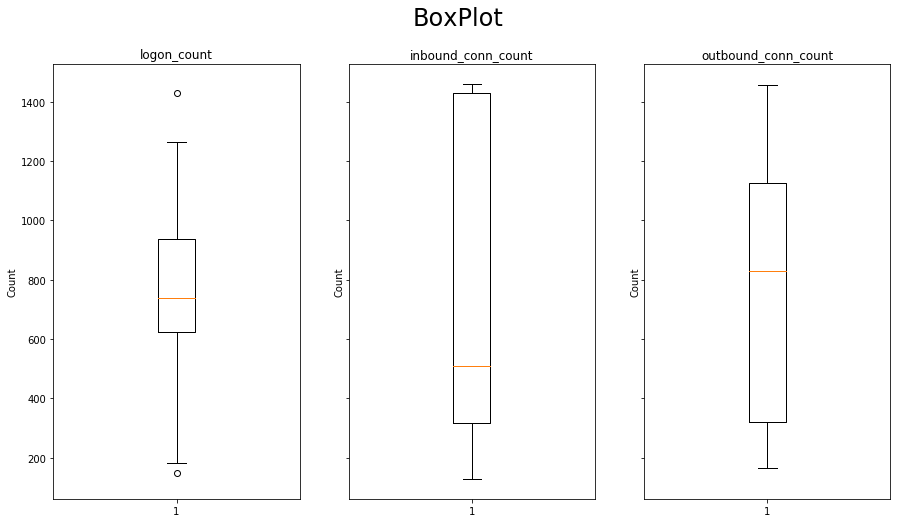

In [7]:
plt.close()

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False,figsize=(15,8))
axs[0].boxplot(logon_count)
axs[0].title.set_text('logon_count')
axs[0].set_ylabel('Count')


axs[1].boxplot(inbound_conn_count)
axs[1].title.set_text('inbound_conn_count')
axs[1].set_ylabel('Count')


axs[2].boxplot(outbound_conn_count)
axs[2].title.set_text('outbound_conn_count')
axs[2].set_ylabel('Count')


fig.suptitle("BoxPlot", fontsize=24,)

plt.show()
plt.close()


### Density plot for logon_count and inbound_conn_count and outbound_conn_count

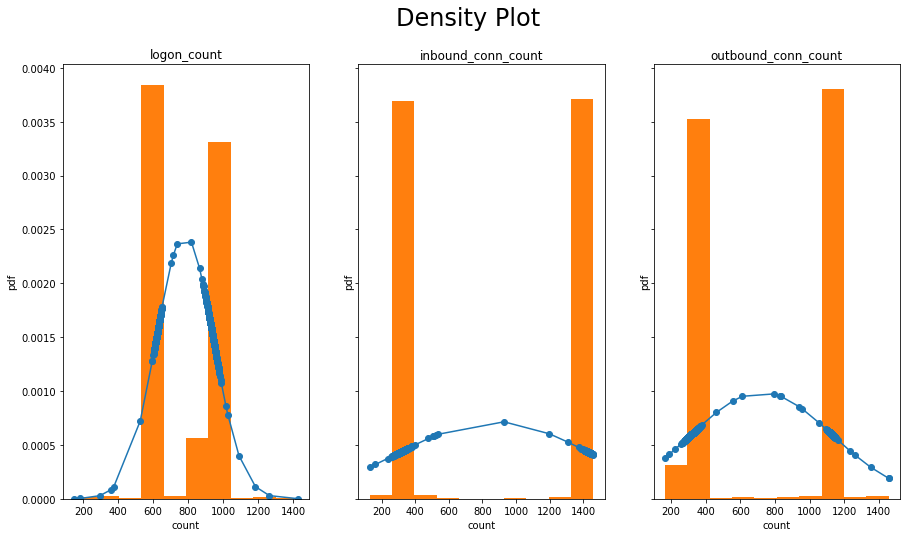

In [8]:
plt.close()

h1 = sorted(logon_count)
h2 = sorted(inbound_conn_count)
h3 = sorted(outbound_conn_count)

fit1 = stats.norm.pdf(h1, np.mean(h1), np.std(h1))
fit2 = stats.norm.pdf(h2, np.mean(h2), np.std(h2))
fit3 = stats.norm.pdf(h3, np.mean(h3), np.std(h3))


fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False,figsize=(15,8))

axs[0].plot(h1,fit1,'-o')
axs[0].hist(h1,density=True)
axs[0].title.set_text('logon_count')
axs[0].set_ylabel('pdf')
axs[0].set_xlabel('count')


axs[1].plot(h2,fit2,'-o')
axs[1].hist(h2,density=True)
axs[1].title.set_text('inbound_conn_count')
axs[1].set_ylabel('pdf')
axs[1].set_xlabel('count')


axs[2].plot(h3,fit3,'-o')
axs[2].hist(h3,density=True)
axs[2].title.set_text('outbound_conn_count')
axs[2].set_ylabel('pdf')
axs[2].set_xlabel('count')

fig.suptitle("Density Plot", fontsize=24)



plt.show()
plt.close()



### Histogram plot for logon_count and inbound_conn_count and outbound_conn_count

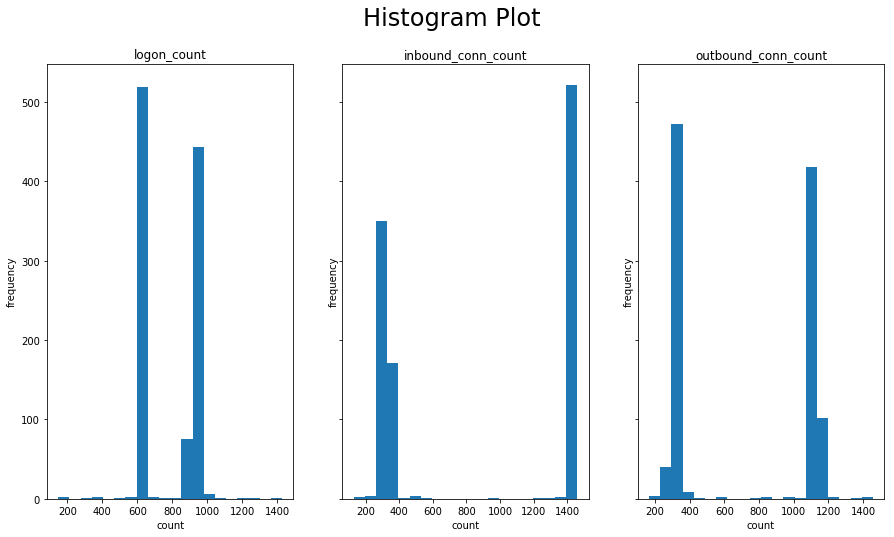

In [9]:
plt.close()
n_bins = 20

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False,figsize=(15,8))

axs[0].hist(logon_count, bins=n_bins)
axs[0].title.set_text('logon_count')
axs[0].set_ylabel('frequency')
axs[0].set_xlabel('count')


axs[1].hist(inbound_conn_count, bins=n_bins)
axs[1].title.set_text('inbound_conn_count')
axs[1].set_ylabel('frequency')
axs[1].set_xlabel('count')


axs[2].hist(outbound_conn_count, bins=n_bins)
axs[2].title.set_text('outbound_conn_count')
axs[2].set_ylabel('frequency')
axs[2].set_xlabel('count')

fig.suptitle("Histogram Plot", fontsize=24)

plt.show()
plt.close()

# Define the columns on which Model shall be trained

In [10]:
cat_colnames = ["increase_activity","lateral_movement"]
num_colnames = ["logon_count","inbound_conn_count","outbound_conn_count"]
ip_profile_df = ip_profile_sdf.toPandas()
if len(num_colnames)>0:
    num_data = ip_profile_df[num_colnames].values.astype(np.float64)
if len(cat_colnames)>0:
    cat_data = ip_profile_df[cat_colnames].values

# Batch Training

### Isolation Forest Pipelinemodel

In [11]:
standard_scaler = None
if len(num_colnames)>0:
    standard_scaler = StandardScaler()
    num_data_normalized = standard_scaler.fit_transform(num_data)

In [12]:
one_hot_encoder = None
if len(cat_colnames)>0:
    one_hot_encoder = OneHotEncoder()
    cat_data_encoded = one_hot_encoder.fit_transform(cat_data).toarray()

In [13]:
if len(num_colnames)>0 and len(cat_colnames)>0:
    data = np.concatenate((num_data_normalized,cat_data_encoded),axis=1)
elif len(cat_colnames):
    data = cat_data_encoded
elif len(num_colnames):
    data = num_data_normalized

In [14]:
isolation_forest = IsolationForest(behaviour='new',n_estimators=1000,max_samples=0.3,max_features=min(2,len(num_colnames+cat_colnames)),bootstrap=True,
                                         contamination="auto",
                                         random_state=42)
isolation_forest_model = isolation_forest.fit(data)

In [15]:
ip_profile_df["score"] = isolation_forest_model.decision_function(data).reshape(-1, 1)*-1

### scoring pipelinemodel

In [16]:
score = ip_profile_df["score"].values.reshape(-1, 1)
minmax_scaler = MinMaxScaler(feature_range=(0,100))
scoring_pipeline = Pipeline(steps=[("MinMaxScaler",minmax_scaler)])
scoring_pipeline_model = scoring_pipeline.fit(score)

In [17]:
model_path = PROFILE_ANOMALY_MODEL_PATH.format(data_source=data_source,\
                                  entity_type=entity_type,anomaly_type=anomaly_type,time_window=time_window,\
                                 model_type=model_type,model_name=model_name)

os.system("hdfs dfs -rm -r "+model_path)

0

### Save the Isolation Forest (IF) Pipelinemodel

In [18]:
isolation_forest_model_rdd = sc.parallelize([{"cat_colnames":cat_colnames,"num_colnames":num_colnames,"standard_scaler":standard_scaler,"one_hot_encoder":one_hot_encoder,"isolation_forest_model":isolation_forest_model}])
isolation_forest_model_rdd.saveAsPickleFile(model_path+"/if_pipeline_model")

### Save the Scoring Pipelinemodel

In [19]:
scoring_pipeline_model_rdd = sc.parallelize([scoring_pipeline_model])
scoring_pipeline_model_rdd.saveAsPickleFile(model_path+"/scoring_pipeline_model")